In [70]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import re

In [2]:
# Parsing file, each line is a Python dictionary
with open("./scrapes/ted_talks.txt", 'r', encoding="utf-8") as infile:
    lines = infile.readlines()
    
talks = [eval(line) for line in lines]

In [3]:
talks[0].keys()

dict_keys(['talk_id', 'date', 'title', 'language', 'tags', 'speaker_id', 'num_views', 'speaker', 'event', 'categories', 'num_comments', 'duration', 'tokens'])

### Duration

In [4]:
durations = [talk["duration"] for talk in talks]

In [5]:
avg_duration_seconds = np.mean(durations)
avg_duration_minutes = avg_duration_seconds / 60
avg_duration_minutes

13.333988049834733

In [6]:
talks[0]["categories"]

[{'id': 7, 'name': 'Funny', 'count': 20966},
 {'id': 1, 'name': 'Beautiful', 'count': 4973},
 {'id': 9, 'name': 'Ingenious', 'count': 6550},
 {'id': 3, 'name': 'Courageous', 'count': 3508},
 {'id': 11, 'name': 'Longwinded', 'count': 419},
 {'id': 2, 'name': 'Confusing', 'count': 268},
 {'id': 8, 'name': 'Informative', 'count': 8106},
 {'id': 22, 'name': 'Fascinating', 'count': 11288},
 {'id': 21, 'name': 'Unconvincing', 'count': 314},
 {'id': 24, 'name': 'Persuasive', 'count': 11237},
 {'id': 23, 'name': 'Jaw-dropping', 'count': 4617},
 {'id': 25, 'name': 'OK', 'count': 1241},
 {'id': 26, 'name': 'Obnoxious', 'count': 222},
 {'id': 10, 'name': 'Inspiring', 'count': 26312}]

In [7]:
import matplotlib.pyplot as plt

Text(0.5,1,'Duration vs. Views')

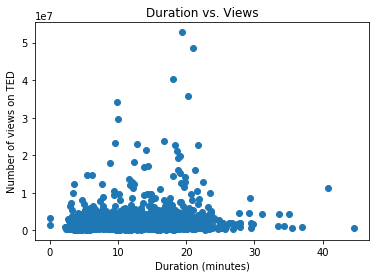

In [8]:
num_views = [talk['num_views'] for talk in talks]
plt.scatter(np.array(durations) / 60, num_views)
plt.xlabel("Duration (minutes)")
plt.ylabel("Number of views on TED")
plt.title("Duration vs. Views")

Text(0.5,1,'Duration vs. Comments')

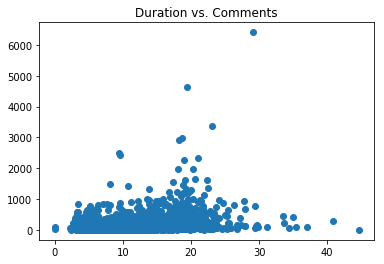

In [9]:
num_comments = [talk['num_comments'] for talk in talks]
plt.scatter(np.array(durations) / 60, num_comments)
plt.title("Duration vs. Comments")

Text(0.5,1,'Views vs. Comments')

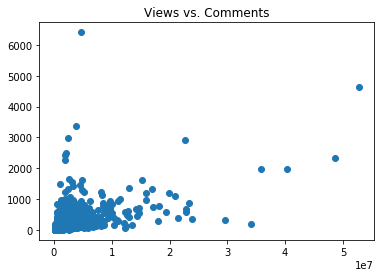

In [10]:
plt.scatter(num_views, num_comments)
plt.title("Views vs. Comments")

In [11]:
np.argmax(num_comments)

150

In [12]:
talks[150]['title'], talks[150]['speaker']

('Militant atheism', 'Richard Dawkins')

In [13]:
np.argmax(num_views)

0

In [14]:
# haha duh, I scraped on views!
talks[0]['title'], talks[0]['speaker']

('Do schools kill creativity?', 'Ken Robinson')

### Get word counts for talks

In [15]:
test_tokens = talks[0]['tokens'][:10]
test_tokens

['Good morning. How are you?',
 '(Laughter)',
 "It's been great, hasn't it?",
 "I've been blown away by the whole thing.",
 "In fact, I'm leaving.",
 '(Laughter)',
 'There have been three themes\nrunning through the conference',
 'which are relevant\nto what I want to talk about.',
 'One is the extraordinary\nevidence of human creativity',
 "in all of the presentations that we've had"]

In [16]:
test_token = test_tokens[7]
test_token

'which are relevant\nto what I want to talk about.'

In [17]:
import nltk
# nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/parker/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [18]:
nltk.word_tokenize(test_token)

['which',
 'are',
 'relevant',
 'to',
 'what',
 'I',
 'want',
 'to',
 'talk',
 'about',
 '.']

That's cool, but it leaves in the punctuation

In [19]:
# Creating a custom tokenizer that only keeps words (groups of chars) or numbers (groups of digits)
from nltk.tokenize import RegexpTokenizer
punct_tokenizer = RegexpTokenizer(r'\w+|\d+')

In [20]:
punct_tokenizer.tokenize(test_token)

['which', 'are', 'relevant', 'to', 'what', 'I', 'want', 'to', 'talk', 'about']

In [21]:
# Unforunately it splits numbers up, but that's not too bad (especially since people actually pronounce numbers) :shrug:
punct_tokenizer.tokenize("1,000,234,543")

['1', '000', '234', '543']

In [22]:
num_words = 0
for token in test_tokens:
    # Ignore audience cues (should start with '(', based on experience at least!)
    if token[0] == '(':
        pass
    else:
        num_words += len(punct_tokenizer.tokenize(token))

In [23]:
num_words

62

In [24]:
punct_tokenizer.tokenize("I'm actually two words: 'I' and 'Am'")

['I', 'm', 'actually', 'two', 'words', 'I', 'and', 'Am']

Alright let's actually get some word counts now

In [25]:
def count_words(tokens):
    
    return sum([len(punct_tokenizer.tokenize(token)) for token in tokens if token[0] != '('])

In [26]:
count_words(test_tokens)

62

In [27]:
# testing first
for talk in talks[:1]:
    talk['num_words'] = count_words(talk['tokens'])

In [28]:
talks[0]['num_words']

3251

In [29]:
# sweet, let's gooooooo
for talk in talks:
    talk['num_words'] = count_words(talk['tokens'])

That was so much quicker than I thought it would be.  Took about 2.5 seconds :')

In [30]:
num_words = [talk['num_words'] for talk in talks]

Text(0.5,1,'Duration vs. Number of Words')

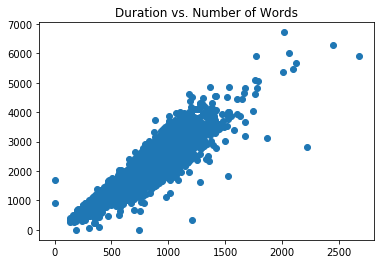

In [31]:
plt.scatter(durations, num_words)
plt.title("Duration vs. Number of Words")

In [32]:
np.corrcoef(durations, num_words)

array([[1.        , 0.91642208],
       [0.91642208, 1.        ]])

### I wonder if presenters who talk fast are considered 'confusing'

In [33]:
words_per_min = np.array(num_words) / (np.array(durations) / 60)

/home/parker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


Yikes, I have some zero durations in there?  I guess I didn't filter out my scrapes enough...

In [34]:
np.argwhere(np.array(durations) == 0)

array([[ 255],
       [1116]])

In [35]:
talks[255]['title'], talks[255]['speaker']

('How I learned to read -- and trade stocks -- in prison',
 'Curtis "Wall Street" Carroll')

In [36]:
talks[1116]['title'], talks[1116]['speaker']

('How I fail at being disabled', 'Susan Robinson')

Nope! TED messed up on those bad boys, I'll rewrite them manually.

In [37]:
talks[255]['duration'] = 11 * 60 + 4
talks[1116]['duration'] = 7 * 60 + 48

In [38]:
durations = np.array([talk['duration'] for talk in talks])
words_per_min = np.array(num_words) / (durations / 60)

In [39]:
rankings = np.array([talk['categories'] for talk in talks])

In [43]:
# For each set of rankings I'll need to go through the list until I find 'name':'Confusing' or 'id' == 2
confusing_rankings = []
for talk_rankings in rankings:
    for rank in talk_rankings:
        if rank['name'] == 'Confusing':
            confusing_rankings.append(rank['count'])
            # I just hope that all the talks have a 'confusing' ranking... otherwise I'll need to default the value to None

In [44]:
len(confusing_rankings)

2622

Nice!

Text(0.5,1,"Words per Min vs. Number of 'Confusing' Rankings (not normalized)")

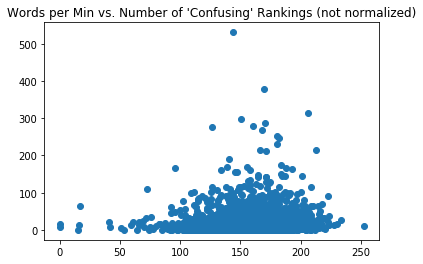

In [45]:
plt.scatter(words_per_min, confusing_rankings)
plt.title("Words per Min vs. Number of 'Confusing' Rankings (not normalized)")

Let me normalize the number of confusing rankings to the number of total rankings

In [46]:
total_rankings = []
for talk_rankings in rankings:
    total_rankings.append(sum([rank['count'] for rank in talk_rankings]))
        

In [47]:
total_rankings = np.array(total_rankings)
confusing_rankings = np.array(confusing_rankings)

In [48]:
# This should now be the percent of rankings that were 'confusing'
confusing_rankings_percent = confusing_rankings / total_rankings * 100

Text(0.5,1,"Words per Min vs. Percent 'Confusing' Rankings")

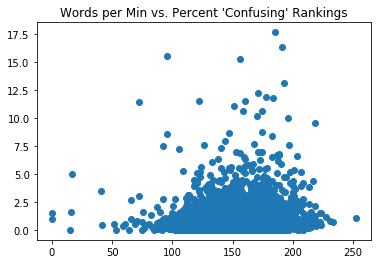

In [49]:
plt.scatter(words_per_min, confusing_rankings_percent)
plt.title("Words per Min vs. Percent 'Confusing' Rankings")

Not too convincing... but there **is** a positive trend if you don't focus on the giant heap of blue

In [50]:
np.corrcoef(words_per_min, confusing_rankings_percent, 1)

array([[1.        , 0.05818168],
       [0.05818168, 1.        ]])

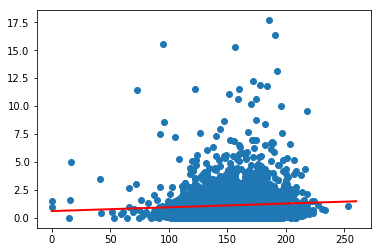

In [51]:
plt.scatter(words_per_min, confusing_rankings_percent)
plt.plot([0, 260], np.poly1d(np.polyfit(words_per_min, confusing_rankings_percent, 1))([0, 260]), c='r', lw=2)

Heh... that's not so good.

### Making sure categories are consistent

In [52]:
{1, 4, 2} == {4, 1, 2}

True

In [53]:
first_rankings = set(rating['name'] for rating in talks[0]['categories'])
first_rankings

{'Beautiful',
 'Confusing',
 'Courageous',
 'Fascinating',
 'Funny',
 'Informative',
 'Ingenious',
 'Inspiring',
 'Jaw-dropping',
 'Longwinded',
 'OK',
 'Obnoxious',
 'Persuasive',
 'Unconvincing'}

In [54]:
all(first_rankings == set(rating['name'] for rating in talk['categories']) for talk in talks)

True

:) Nice

### Looking at correlations between rankings

In [55]:
# Creating table of just rankings (cols = category name, rows = talks, vals = votes)
rankings = pd.DataFrame(columns=first_rankings)
rankings

,Informative,Inspiring,Fascinating,Courageous,Ingenious,Beautiful,Confusing,Jaw-dropping,Longwinded,Unconvincing,Persuasive,Obnoxious,Funny,OK


In [56]:
for talk in talks:
    categs = talk['categories']
    row_to_add = {}
    for categ in categs:
        row_to_add[categ['name']] = categ['count']
    rankings = rankings.append(row_to_add, ignore_index=True)

In [57]:
rankings.head()

,Informative,Inspiring,Fascinating,Courageous,Ingenious,Beautiful,Confusing,Jaw-dropping,Longwinded,Unconvincing,Persuasive,Obnoxious,Funny,OK
0,8106,26312,11288,3508,6550,4973,268,4617,419,314,11237,222,20966,1241
1,11124,23687,12416,7206,1633,3693,232,4080,371,367,6911,173,1081,1228
2,7629,23816,8296,1366,3794,1891,125,2916,410,971,9813,298,442,1438
3,4999,22918,5008,8871,1172,8469,161,2200,305,250,3696,139,5649,523
4,495,513,1161,307,2153,278,27,311,52,71,117,65,9174,184


In [58]:
rankings.shape

(2622, 14)

In [59]:
rankings.corr()

""


In [60]:
rankings.dtypes

Informative     object
Inspiring       object
Fascinating     object
Courageous      object
Ingenious       object
Beautiful       object
Confusing       object
Jaw-dropping    object
Longwinded      object
Unconvincing    object
Persuasive      object
Obnoxious       object
Funny           object
OK              object
dtype: object

In [61]:
rankings = rankings.astype(int)

In [62]:
ranking_corrs = rankings.corr()
ranking_corrs

,Informative,Inspiring,Fascinating,Courageous,Ingenious,Beautiful,Confusing,Jaw-dropping,Longwinded,Unconvincing,Persuasive,Obnoxious,Funny,OK
Informative,1.000000,0.707313,0.813329,0.475943,0.533983,0.455453,0.378611,0.402413,0.457589,0.286762,0.805010,0.228444,0.413932,0.659977
Inspiring,0.707313,1.000000,0.728834,0.691951,0.539777,0.722321,0.337380,0.388129,0.459687,0.266054,0.802118,0.243191,0.496224,0.601264
Fascinating,0.813329,0.728834,1.000000,0.502631,0.663751,0.631240,0.441304,0.651710,0.481650,0.266061,0.666513,0.247735,0.455788,0.598082
Courageous,0.475943,0.691951,0.502631,1.000000,0.239799,0.636110,0.281024,0.315348,0.347148,0.223000,0.513629,0.259779,0.274553,0.370920
Ingenious,0.533983,0.539777,0.663751,0.239799,1.000000,0.321439,0.297362,0.549935,0.313466,0.188342,0.564801,0.179519,0.584326,0.457354
Beautiful,0.455453,0.722321,0.631240,0.636110,0.321439,1.000000,0.283091,0.431423,0.352085,0.165728,0.425803,0.190723,0.315732,0.398271
Confusing,0.378611,0.337380,0.441304,0.281024,0.297362,0.283091,1.000000,0.278159,0.666152,0.666279,0.373959,0.589882,0.263050,0.563865
Jaw-dropping,0.402413,0.388129,0.651710,0.315348,0.549935,0.431423,0.278159,1.000000,0.243098,0.140612,0.295636,0.165669,0.217174,0.288140
Longwinded,0.457589,0.459687,0.481650,0.347148,0.313466,0.352085,0.666152,0.243098,1.000000,0.538809,0.494867,0.531871,0.288299,0.651039
Unconvincing,0.286762,0.266054,0.266061,0.223000,0.188342,0.165728,0.666279,0.140612,0.538809,1.000000,0.368190,0.776101,0.139517,0.510925


[Great Stack Overflow answer about getting the upper triangle](https://stackoverflow.com/questions/34417685/melt-the-upper-triangular-matrix-of-a-pandas-dataframe).  I'm modifying slightly (~) to exclude diagonal as well.

In [63]:
ranking_corrs_tri = ranking_corrs.where(~np.triu(np.ones(ranking_corrs.shape)).astype(np.bool))

ranking_corrs_stack = ranking_corrs_tri.stack().reset_index()
ranking_corrs_stack.columns = ['Row','Column','Value']

In [64]:
ranking_corrs_tri.head()

,Informative,Inspiring,Fascinating,Courageous,Ingenious,Beautiful,Confusing,Jaw-dropping,Longwinded,Unconvincing,Persuasive,Obnoxious,Funny,OK
Informative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Inspiring,0.707313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fascinating,0.813329,0.728834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Courageous,0.475943,0.691951,0.502631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ingenious,0.533983,0.539777,0.663751,0.239799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
ranking_corrs_stack = ranking_corrs_stack.sort_values("Value", ascending=False)
ranking_corrs_stack.head(20)

,Row,Column,Value
1,Fascinating,Informative,0.813329
45,Persuasive,Informative,0.805010
46,Persuasive,Inspiring,0.802118
64,Obnoxious,Unconvincing,0.776101
2,Fascinating,Inspiring,0.728834
11,Beautiful,Inspiring,0.722321
0,Inspiring,Informative,0.707313
4,Courageous,Inspiring,0.691951
47,Persuasive,Fascinating,0.666513
42,Unconvincing,Confusing,0.666279


I think the Obnoxious-Unconvincing correlation is very funny!

I'm curious what correlation Longwinded has with anything good...

In [66]:
ranking_corrs_stack[(ranking_corrs_stack['Row'] == "Longwinded") | (ranking_corrs_stack['Column'] == "Longwinded")]

,Row,Column,Value
34,Longwinded,Confusing,0.666152
86,OK,Longwinded,0.651039
44,Unconvincing,Longwinded,0.538809
63,Obnoxious,Longwinded,0.531871
53,Persuasive,Longwinded,0.494867
30,Longwinded,Fascinating,0.481650
29,Longwinded,Inspiring,0.459687
28,Longwinded,Informative,0.457589
33,Longwinded,Beautiful,0.352085
31,Longwinded,Courageous,0.347148


Ouch... alright if I ever give a TED talk I'll make sure not to be longwinded!

What else is highly correlated with bad rankings?

In [67]:
bad_rankings = ["Confusing", "Obnoxious", "Unconvincing", "OK"]

In [68]:
rcs = ranking_corrs_stack
rcs[(rcs['Row'].isin(bad_rankings)) | (rcs['Column'].isin(bad_rankings))]

,Row,Column,Value
64,Obnoxious,Unconvincing,0.776101
42,Unconvincing,Confusing,0.666279
34,Longwinded,Confusing,0.666152
78,OK,Informative,0.659977
86,OK,Longwinded,0.651039
88,OK,Persuasive,0.644424
79,OK,Inspiring,0.601264
80,OK,Fascinating,0.598082
61,Obnoxious,Confusing,0.589882
84,OK,Confusing,0.563865


...probably should have seen that coming... the bad stuff is correlated with the bad stuff

### I want to look at what words are used most overall, then break that up into categories 
I'm going to need to associate word counts as `{word: count}` for the talks in order to do this effectively.

I'm thinking about the punctuation tokenizer I used before... that would probably work but it just feels wrong splitting up numbers.  Plus, I want to look at what categories of talks reference numbers more than others.

In [ ]:
# Number are separated by commas, nothing,else,is,separated,by,a,comma,and,no,whitespace so I'll just remove commas


In [84]:
string = "Testing, once again. This 10,000 sentence is! Not 'at all' understandable---for you (Laughter)... or me in that, case."
punct_tokenizer.tokenize(string)

['Testing',
 'once',
 'again',
 'This',
 '10',
 '000',
 'sentence',
 'is',
 'Not',
 'at',
 'all',
 'understandable',
 'for',
 'you',
 'Laughter',
 'or',
 'me',
 'in',
 'that',
 'case']

In [85]:
re.sub(',', '', string)

"Testing once again. This 10000 sentence is! Not 'at all' understandable---for you (Laughter)... or me in that case."

In [93]:
# Need to remove inline (Laughter) and (Applause)
# The expression \([^)]*\) removes anything between parenthesis, then I just tack on the ,
re.sub(r'\([^)]*\)|,', '', string)

"Testing once again. This 10000 sentence is! Not 'at all' understandable---for you ... or me in that case."

In [104]:
for talk in talks:
    talk['words'] = []
    for cue in talk['tokens']:
        if cue[0] != '(':
            talk['words'].extend(
                punct_tokenizer.tokenize(re.sub(r'\([^)]*\)|,', '', cue).lower())
            )

In [103]:
pd.value_counts(talks[0]['words'])

the            153
and            103
to              80
you             78
of              75
a               74
we              63
i               62
in              56
it              52
that            46
is              45
s               45
t               44
they            44
was             41
she             41
this            30
on              29
have            26
think           26
if              25
education       22
said            22
all             22
he              22
at              21
re              20
about           20
are             19
              ... 
tree             1
confusing        1
research         1
privately        1
chestnut         1
shirts           1
retiring         1
15               1
wall             1
class            1
interaction      1
needs            1
struck           1
dynamic          1
combination      1
games            1
maybe            1
yeah             1
musical          1
otherwise        1
abstract         1
else        

In [105]:
for talk in talks:
    talk['word_counts'] = pd.value_counts(talk['words'])

Alright.  Now I have a list of words per talk, and a count of words per talk.
### Let's see what words are used most (we can ignore 'the' and 'and' later...)

In [111]:
# Testing pd.Series.add
s1 = pd.Series([1, 2, 3, 4], index=[0, 1, 2, 3])
s2 = pd.Series([0, 0, 0, 0, 10], index=[0, 1, 2, 3, 4])
s1.add(s2, fill_value=0)

0     1.0
1     2.0
2     3.0
3     4.0
4    10.0
dtype: float64

In [122]:
total_word_counts = pd.Series()
for talk in talks:
    total_word_counts = total_word_counts.add(talk['word_counts'], fill_value=0)

In [131]:
total_word_counts = total_word_counts.sort_values(ascending=False)

That one was the kicker... took a couple minutes

In [133]:
pd.options.display.max_rows = 999

In [134]:
total_word_counts.head(999)

the              249097.0
and              179048.0
to               154592.0
of               138588.0
a                127118.0
that             114505.0
i                 99043.0
in                94642.0
it                87911.0
we                82980.0
you               81590.0
is                74980.0
s                 66476.0
this              57920.0
so                43381.0
they              40159.0
for               37101.0
was               37053.0
are               34583.0
but               33024.0
have              32932.0
what              31599.0
on                31356.0
with              30551.0
can               28475.0
t                 27491.0
about             25311.0
be                25058.0
there             24373.0
as                24199.0
not               23439.0
at                23140.0
my                22659.0
all               22582.0
do                21434.0
people            20873.0
one               20817.0
re                20063.0
like        